# Import Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [5]:
# Train Phase transformations
mean, std = ( 0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
train_transforms = transforms.Compose([
                                       transforms.Resize((32, 32)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.0, 6.0)),
                                       transforms.RandomAffine(degrees = 0, translate = (0.05, 0.05)),
                                       transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std),
                                       transforms.RandomErasing(p=0.2, scale=(0.05,0.05), ratio=(0.05,0.5))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std)
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
traindata = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
testdata = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
traindata.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(traindata, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(testdata, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [9]:
#The inverse normalization should be
# x   = z*sigma + mean
#     = (z + mean/sigma) * sigma
#     = (z - (-mean/sigma)) / (1/sigma),
#     since the normalization process is actually z = (x - mean) / sigma if you look carefully at the documentation of transforms.Normalize.

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: 153600000
torch.Size([128, 3, 32, 32])
torch.Size([128])
cat


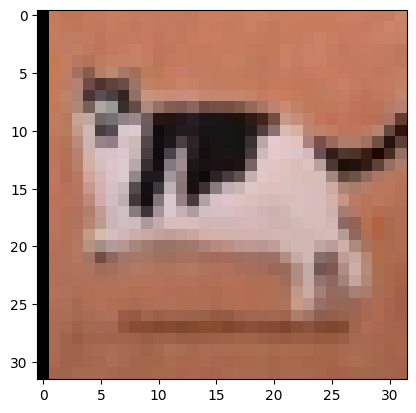

In [18]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
import numpy as np
train_data = traindata.data

print('[Train]')
print(' - Numpy Shape:', traindata.data.shape)
print(' - Tensor Shape:', traindata.data.size)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(np.transpose(inv_normalize(images[0]), (1, 2, 0)))
print(traindata.classes[labels[0]])


It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

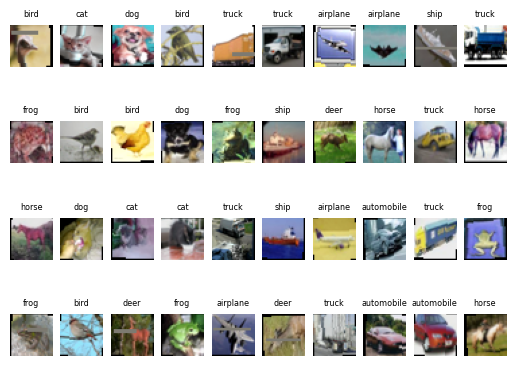

In [11]:
figure = plt.figure()
num_of_images = 40


for index in range(1, num_of_images + 1):
    plt.subplot(4, 10, index)
    plt.axis('off')
    image= inv_normalize(images[index])
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.title(traindata.classes[labels[index]],size='xx-small')

# Model Skeleton For all Normalization

In [50]:
from utils import *
from model import *

# Batch Normalization

In [14]:
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             864
       BatchNorm2d-2           [-1, 32, 34, 34]              64
              ReLU-3           [-1, 32, 34, 34]               0
           Dropout-4           [-1, 32, 34, 34]               0
            Conv2d-5           [-1, 32, 36, 36]           9,216
       BatchNorm2d-6           [-1, 32, 36, 36]              64
              ReLU-7           [-1, 32, 36, 36]               0
           Dropout-8           [-1, 32, 36, 36]               0
            Conv2d-9           [-1, 12, 36, 36]             384
      BatchNorm2d-10           [-1, 12, 36, 36]              24
             ReLU-11           [-1, 12, 36, 36]               0
          Dropout-12           [-1, 12, 36, 36]               0
        MaxPool2d-13           [-1, 12, 18, 18]               0
           Conv2d-14           [-1, 32,

In [51]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,verbose=True,min_lr=0.001,factor=0.2)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step(test_losses[-1])

EPOCH: 0


Loss=1.1279330253601074 Batch_id=390 Accuracy=41.30: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 1.4278, Accuracy: 4939/10000 (49.39%)

EPOCH: 1


Loss=0.9068873524665833 Batch_id=390 Accuracy=56.47: 100%|██████████| 391/391 [01:03<00:00,  6.16it/s]



Test set: Average loss: 1.0578, Accuracy: 6168/10000 (61.68%)

EPOCH: 2


Loss=0.9338598251342773 Batch_id=390 Accuracy=62.81: 100%|██████████| 391/391 [00:59<00:00,  6.59it/s]



Test set: Average loss: 1.0381, Accuracy: 6270/10000 (62.70%)

EPOCH: 3


Loss=0.8916972279548645 Batch_id=390 Accuracy=66.34: 100%|██████████| 391/391 [00:57<00:00,  6.76it/s]



Test set: Average loss: 0.8756, Accuracy: 6851/10000 (68.51%)

EPOCH: 4


Loss=0.9540910720825195 Batch_id=390 Accuracy=68.40: 100%|██████████| 391/391 [01:00<00:00,  6.47it/s]



Test set: Average loss: 0.8664, Accuracy: 6994/10000 (69.94%)

EPOCH: 5


Loss=0.9261319041252136 Batch_id=390 Accuracy=70.15: 100%|██████████| 391/391 [01:07<00:00,  5.79it/s]



Test set: Average loss: 0.8372, Accuracy: 7038/10000 (70.38%)

EPOCH: 6


Loss=0.8491224050521851 Batch_id=390 Accuracy=71.29: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]



Test set: Average loss: 0.7747, Accuracy: 7252/10000 (72.52%)

EPOCH: 7


Loss=0.8296691179275513 Batch_id=390 Accuracy=72.61: 100%|██████████| 391/391 [00:56<00:00,  6.87it/s]



Test set: Average loss: 0.8083, Accuracy: 7119/10000 (71.19%)

EPOCH: 8


Loss=0.7455145120620728 Batch_id=390 Accuracy=73.27: 100%|██████████| 391/391 [01:00<00:00,  6.47it/s]



Test set: Average loss: 0.7520, Accuracy: 7419/10000 (74.19%)

EPOCH: 9


Loss=0.8465720415115356 Batch_id=390 Accuracy=73.90: 100%|██████████| 391/391 [00:57<00:00,  6.79it/s]



Test set: Average loss: 0.7560, Accuracy: 7372/10000 (73.72%)

EPOCH: 10


Loss=0.8079122304916382 Batch_id=390 Accuracy=74.64: 100%|██████████| 391/391 [00:57<00:00,  6.78it/s]



Test set: Average loss: 0.7238, Accuracy: 7423/10000 (74.23%)

EPOCH: 11


Loss=0.6681104898452759 Batch_id=390 Accuracy=75.36: 100%|██████████| 391/391 [01:00<00:00,  6.46it/s]



Test set: Average loss: 0.6926, Accuracy: 7558/10000 (75.58%)

EPOCH: 12


Loss=0.8181449770927429 Batch_id=390 Accuracy=75.65: 100%|██████████| 391/391 [00:58<00:00,  6.66it/s]



Test set: Average loss: 0.6834, Accuracy: 7618/10000 (76.18%)

EPOCH: 13


Loss=0.7021090388298035 Batch_id=390 Accuracy=76.15: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]



Test set: Average loss: 0.6845, Accuracy: 7597/10000 (75.97%)

EPOCH: 14


Loss=0.6125884652137756 Batch_id=390 Accuracy=76.52: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]



Test set: Average loss: 0.6627, Accuracy: 7651/10000 (76.51%)

EPOCH: 15


Loss=0.6267236471176147 Batch_id=390 Accuracy=76.78: 100%|██████████| 391/391 [00:58<00:00,  6.66it/s]



Test set: Average loss: 0.7255, Accuracy: 7483/10000 (74.83%)

EPOCH: 16


Loss=0.5647817850112915 Batch_id=390 Accuracy=77.16: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]



Test set: Average loss: 0.6500, Accuracy: 7752/10000 (77.52%)

EPOCH: 17


Loss=0.6882489919662476 Batch_id=390 Accuracy=77.36: 100%|██████████| 391/391 [00:58<00:00,  6.67it/s]



Test set: Average loss: 0.6155, Accuracy: 7855/10000 (78.55%)

EPOCH: 18


Loss=0.655575156211853 Batch_id=390 Accuracy=77.72: 100%|██████████| 391/391 [00:58<00:00,  6.69it/s]



Test set: Average loss: 0.6098, Accuracy: 7907/10000 (79.07%)

EPOCH: 19


Loss=0.7113648653030396 Batch_id=390 Accuracy=77.92: 100%|██████████| 391/391 [00:59<00:00,  6.53it/s]



Test set: Average loss: 0.6565, Accuracy: 7732/10000 (77.32%)



In [16]:
torch.save(model, "./modelBatch")

Text(0.5, 1.0, 'Test Accuracy')

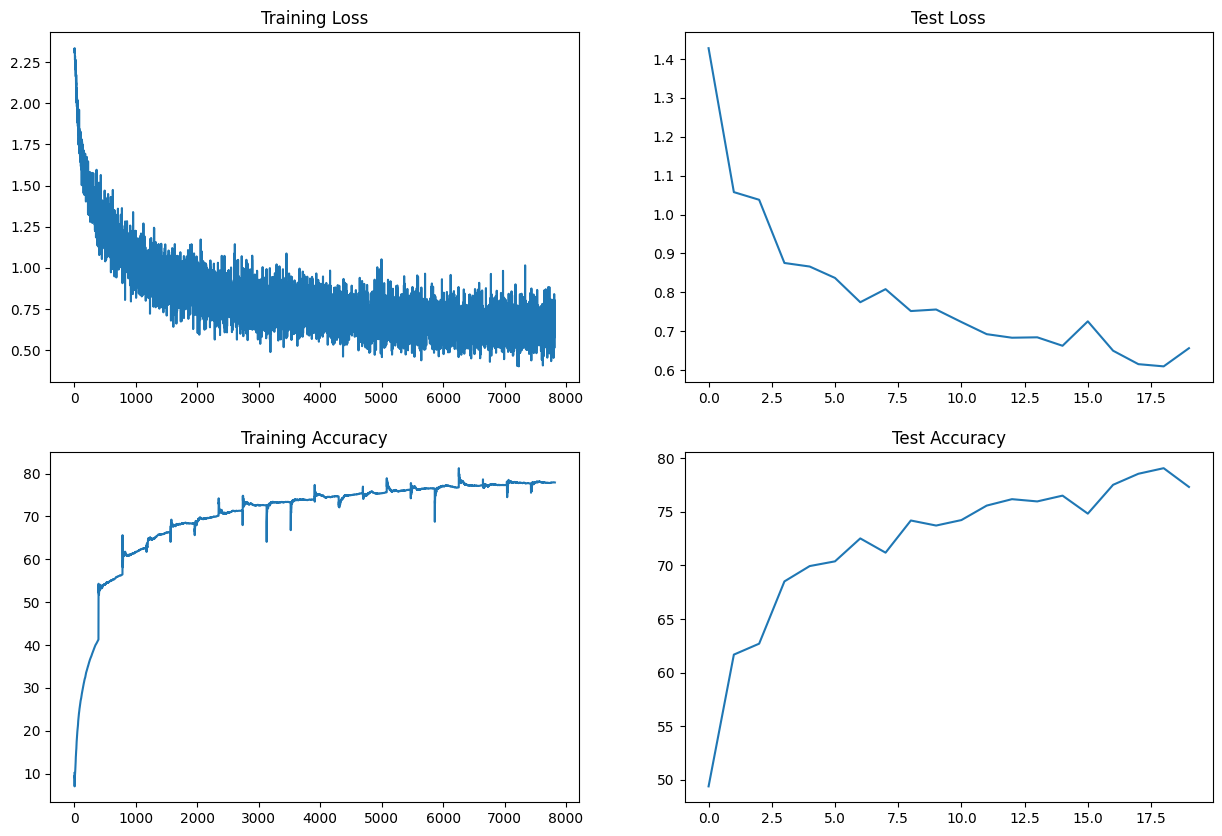

In [54]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Layer norm

In [18]:
train_losses.clear()
test_losses.clear()
train_acc.clear()
test_acc.clear()

modelLayer = Net(norm="Layer").to(device)
summary(modelLayer, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             864
         GroupNorm-2           [-1, 32, 34, 34]              64
              ReLU-3           [-1, 32, 34, 34]               0
           Dropout-4           [-1, 32, 34, 34]               0
            Conv2d-5           [-1, 32, 36, 36]           9,216
         GroupNorm-6           [-1, 32, 36, 36]              64
              ReLU-7           [-1, 32, 36, 36]               0
           Dropout-8           [-1, 32, 36, 36]               0
            Conv2d-9           [-1, 12, 36, 36]             384
        GroupNorm-10           [-1, 12, 36, 36]              24
             ReLU-11           [-1, 12, 36, 36]               0
          Dropout-12           [-1, 12, 36, 36]               0
        MaxPool2d-13           [-1, 12, 18, 18]               0
           Conv2d-14           [-1, 32,

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.SGD(modelLayer.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,verbose=True,min_lr=0.001,factor=0.2)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(modelLayer, device, train_loader, optimizer, epoch)
    test(modelLayer, device, test_loader)
    scheduler.step(test_losses[-1])

EPOCH: 0


Loss=1.7648519277572632 Batch_id=390 Accuracy=26.71: 100%|██████████| 391/391 [00:56<00:00,  6.96it/s]



Test set: Average loss: 1.8830, Accuracy: 3360/10000 (33.60%)

EPOCH: 1


Loss=1.833667516708374 Batch_id=390 Accuracy=40.14: 100%|██████████| 391/391 [00:55<00:00,  7.00it/s]



Test set: Average loss: 1.4995, Accuracy: 4600/10000 (46.00%)

EPOCH: 2


Loss=1.5357534885406494 Batch_id=390 Accuracy=47.70: 100%|██████████| 391/391 [00:59<00:00,  6.59it/s]



Test set: Average loss: 1.4245, Accuracy: 4929/10000 (49.29%)

EPOCH: 3


Loss=1.2741810083389282 Batch_id=390 Accuracy=52.75: 100%|██████████| 391/391 [00:58<00:00,  6.73it/s]



Test set: Average loss: 1.4754, Accuracy: 4768/10000 (47.68%)

EPOCH: 4


Loss=1.181762456893921 Batch_id=390 Accuracy=56.55: 100%|██████████| 391/391 [00:57<00:00,  6.76it/s]



Test set: Average loss: 1.1438, Accuracy: 5923/10000 (59.23%)

EPOCH: 5


Loss=1.0583686828613281 Batch_id=390 Accuracy=59.01: 100%|██████████| 391/391 [00:57<00:00,  6.84it/s]



Test set: Average loss: 1.1190, Accuracy: 6090/10000 (60.90%)

EPOCH: 6


Loss=1.0385074615478516 Batch_id=390 Accuracy=61.02: 100%|██████████| 391/391 [00:59<00:00,  6.55it/s]



Test set: Average loss: 1.0652, Accuracy: 6285/10000 (62.85%)

EPOCH: 7


Loss=0.8395270109176636 Batch_id=390 Accuracy=62.52: 100%|██████████| 391/391 [00:57<00:00,  6.84it/s]



Test set: Average loss: 1.0360, Accuracy: 6276/10000 (62.76%)

EPOCH: 8


Loss=0.9375240206718445 Batch_id=390 Accuracy=63.81: 100%|██████████| 391/391 [00:57<00:00,  6.82it/s]



Test set: Average loss: 0.9954, Accuracy: 6533/10000 (65.33%)

EPOCH: 9


Loss=1.0865064859390259 Batch_id=390 Accuracy=65.35: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]



Test set: Average loss: 0.9902, Accuracy: 6546/10000 (65.46%)

EPOCH: 10


Loss=0.8736572265625 Batch_id=390 Accuracy=66.11: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]



Test set: Average loss: 0.9221, Accuracy: 6763/10000 (67.63%)

EPOCH: 11


Loss=0.9099041819572449 Batch_id=390 Accuracy=67.18: 100%|██████████| 391/391 [01:00<00:00,  6.49it/s]



Test set: Average loss: 0.8697, Accuracy: 6988/10000 (69.88%)

EPOCH: 12


Loss=0.9798128008842468 Batch_id=390 Accuracy=68.21: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]



Test set: Average loss: 0.9886, Accuracy: 6698/10000 (66.98%)

EPOCH: 13


Loss=1.0292876958847046 Batch_id=390 Accuracy=68.72: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]



Test set: Average loss: 0.8812, Accuracy: 6890/10000 (68.90%)

EPOCH: 14


Loss=0.6066011190414429 Batch_id=390 Accuracy=69.16: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]



Test set: Average loss: 0.8388, Accuracy: 7069/10000 (70.69%)

EPOCH: 15


Loss=0.8855134844779968 Batch_id=390 Accuracy=70.06: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]



Test set: Average loss: 0.8476, Accuracy: 7042/10000 (70.42%)

EPOCH: 16


Loss=0.7806299328804016 Batch_id=390 Accuracy=70.76: 100%|██████████| 391/391 [01:03<00:00,  6.21it/s]



Test set: Average loss: 0.8587, Accuracy: 7039/10000 (70.39%)

EPOCH: 17


Loss=0.8065978288650513 Batch_id=390 Accuracy=71.27: 100%|██████████| 391/391 [01:02<00:00,  6.31it/s]



Test set: Average loss: 0.8102, Accuracy: 7208/10000 (72.08%)

EPOCH: 18


Loss=0.9200652837753296 Batch_id=390 Accuracy=71.70: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]



Test set: Average loss: 0.8111, Accuracy: 7180/10000 (71.80%)

EPOCH: 19


Loss=0.8199959993362427 Batch_id=390 Accuracy=71.65: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]



Test set: Average loss: 0.7743, Accuracy: 7293/10000 (72.93%)



In [20]:
torch.save(modelLayer, "./modelLayer")

Text(0.5, 1.0, 'Test Accuracy')

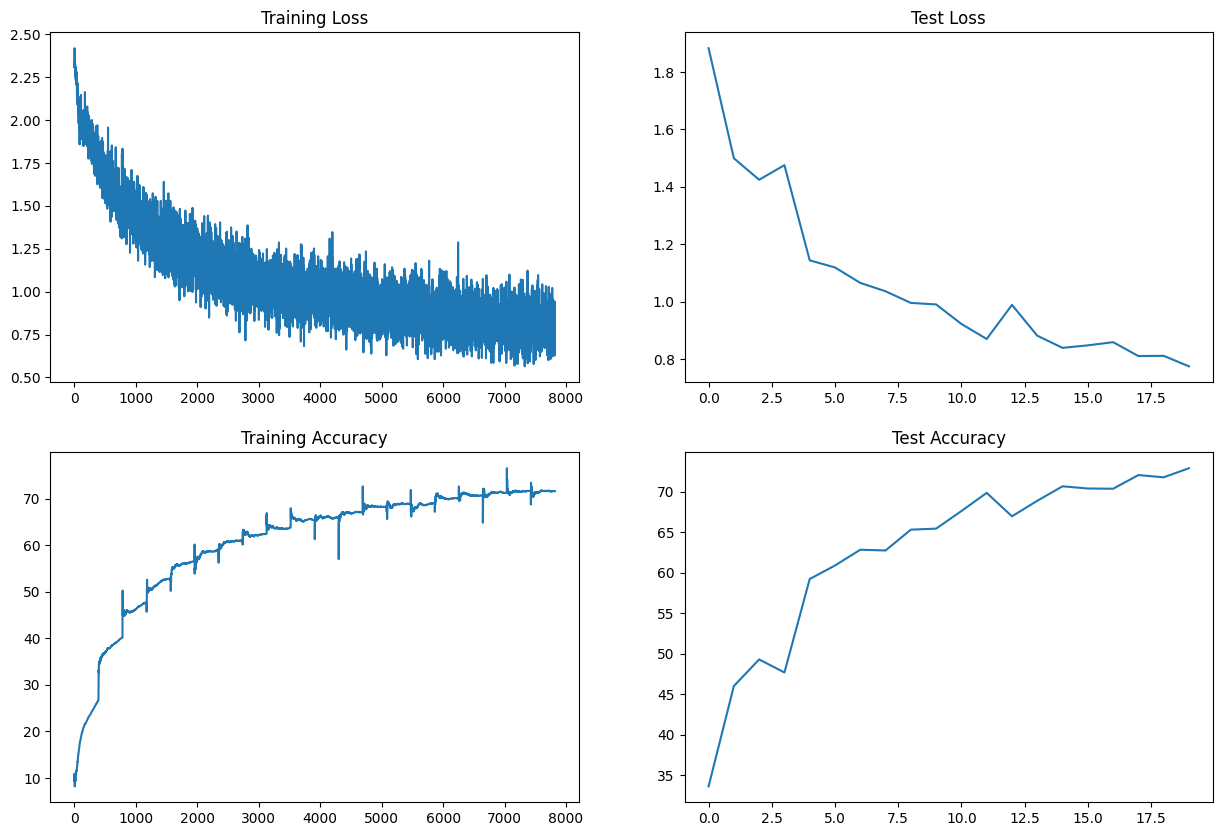

In [21]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Group Norm

In [22]:
modelGroup = Net(norm="GroupNorm",GroupSize=4).to(device)
summary(modelGroup, input_size=(3, 32, 32))

train_losses.clear()
test_losses.clear()
train_acc.clear()
test_acc.clear()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 34, 34]             864
         GroupNorm-2           [-1, 32, 34, 34]              64
              ReLU-3           [-1, 32, 34, 34]               0
           Dropout-4           [-1, 32, 34, 34]               0
            Conv2d-5           [-1, 32, 36, 36]           9,216
         GroupNorm-6           [-1, 32, 36, 36]              64
              ReLU-7           [-1, 32, 36, 36]               0
           Dropout-8           [-1, 32, 36, 36]               0
            Conv2d-9           [-1, 12, 36, 36]             384
        GroupNorm-10           [-1, 12, 36, 36]              24
             ReLU-11           [-1, 12, 36, 36]               0
          Dropout-12           [-1, 12, 36, 36]               0
        MaxPool2d-13           [-1, 12, 18, 18]               0
           Conv2d-14           [-1, 32,

In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.SGD(modelGroup.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,verbose=True,min_lr=0.001,factor=0.2)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(modelGroup, device, train_loader, optimizer, epoch)
    test(modelGroup, device, test_loader)
    scheduler.step(test_losses[-1])

EPOCH: 0


Loss=1.7501411437988281 Batch_id=390 Accuracy=31.85: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]



Test set: Average loss: 1.5730, Accuracy: 4259/10000 (42.59%)

EPOCH: 1


Loss=1.3421351909637451 Batch_id=390 Accuracy=44.75: 100%|██████████| 391/391 [01:11<00:00,  5.48it/s]



Test set: Average loss: 1.3994, Accuracy: 5036/10000 (50.36%)

EPOCH: 2


Loss=1.2130606174468994 Batch_id=390 Accuracy=50.53: 100%|██████████| 391/391 [00:58<00:00,  6.68it/s]



Test set: Average loss: 1.3556, Accuracy: 5097/10000 (50.97%)

EPOCH: 3


Loss=1.077585220336914 Batch_id=390 Accuracy=55.09: 100%|██████████| 391/391 [00:57<00:00,  6.81it/s]



Test set: Average loss: 1.1939, Accuracy: 5711/10000 (57.11%)

EPOCH: 4


Loss=1.1578015089035034 Batch_id=390 Accuracy=57.77: 100%|██████████| 391/391 [00:56<00:00,  6.90it/s]



Test set: Average loss: 1.2837, Accuracy: 5482/10000 (54.82%)

EPOCH: 5


Loss=1.2154059410095215 Batch_id=390 Accuracy=60.08: 100%|██████████| 391/391 [00:57<00:00,  6.81it/s]



Test set: Average loss: 1.0659, Accuracy: 6237/10000 (62.37%)

EPOCH: 6


Loss=1.1166712045669556 Batch_id=390 Accuracy=62.05: 100%|██████████| 391/391 [00:58<00:00,  6.73it/s]



Test set: Average loss: 1.0025, Accuracy: 6470/10000 (64.70%)

EPOCH: 7


Loss=0.7250741124153137 Batch_id=390 Accuracy=63.10: 100%|██████████| 391/391 [00:57<00:00,  6.84it/s]



Test set: Average loss: 0.9978, Accuracy: 6505/10000 (65.05%)

EPOCH: 8


Loss=0.8786309361457825 Batch_id=390 Accuracy=64.52: 100%|██████████| 391/391 [00:57<00:00,  6.84it/s]



Test set: Average loss: 1.1938, Accuracy: 6071/10000 (60.71%)

EPOCH: 9


Loss=0.989982008934021 Batch_id=390 Accuracy=65.33: 100%|██████████| 391/391 [00:57<00:00,  6.82it/s]



Test set: Average loss: 0.9453, Accuracy: 6696/10000 (66.96%)

EPOCH: 10


Loss=0.8688894510269165 Batch_id=390 Accuracy=66.39: 100%|██████████| 391/391 [00:57<00:00,  6.78it/s]



Test set: Average loss: 0.9244, Accuracy: 6751/10000 (67.51%)

EPOCH: 11


Loss=0.8980218768119812 Batch_id=390 Accuracy=67.27: 100%|██████████| 391/391 [00:57<00:00,  6.81it/s]



Test set: Average loss: 0.9034, Accuracy: 6881/10000 (68.81%)

EPOCH: 12


Loss=0.9015158414840698 Batch_id=390 Accuracy=68.65: 100%|██████████| 391/391 [00:57<00:00,  6.77it/s]



Test set: Average loss: 0.8615, Accuracy: 6993/10000 (69.93%)

EPOCH: 13


Loss=1.2088713645935059 Batch_id=390 Accuracy=69.14: 100%|██████████| 391/391 [00:58<00:00,  6.74it/s]



Test set: Average loss: 0.8614, Accuracy: 6995/10000 (69.95%)

EPOCH: 14


Loss=0.9620793461799622 Batch_id=390 Accuracy=69.98: 100%|██████████| 391/391 [00:58<00:00,  6.65it/s]



Test set: Average loss: 0.8448, Accuracy: 7047/10000 (70.47%)

EPOCH: 15


Loss=0.6252924799919128 Batch_id=390 Accuracy=70.38: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]



Test set: Average loss: 0.8151, Accuracy: 7201/10000 (72.01%)

EPOCH: 16


Loss=0.6172410845756531 Batch_id=390 Accuracy=70.79: 100%|██████████| 391/391 [00:59<00:00,  6.63it/s]



Test set: Average loss: 0.8551, Accuracy: 7050/10000 (70.50%)

EPOCH: 17


Loss=0.6619698405265808 Batch_id=390 Accuracy=71.62: 100%|██████████| 391/391 [00:59<00:00,  6.57it/s]



Test set: Average loss: 0.8019, Accuracy: 7201/10000 (72.01%)

EPOCH: 18


Loss=0.8229886889457703 Batch_id=390 Accuracy=72.28: 100%|██████████| 391/391 [00:58<00:00,  6.73it/s]



Test set: Average loss: 0.7736, Accuracy: 7368/10000 (73.68%)

EPOCH: 19


Loss=0.7425006628036499 Batch_id=390 Accuracy=72.44: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s]



Test set: Average loss: 0.8012, Accuracy: 7236/10000 (72.36%)



In [24]:
torch.save(modelGroup, "./modelGroup")

Text(0.5, 1.0, 'Test Accuracy')

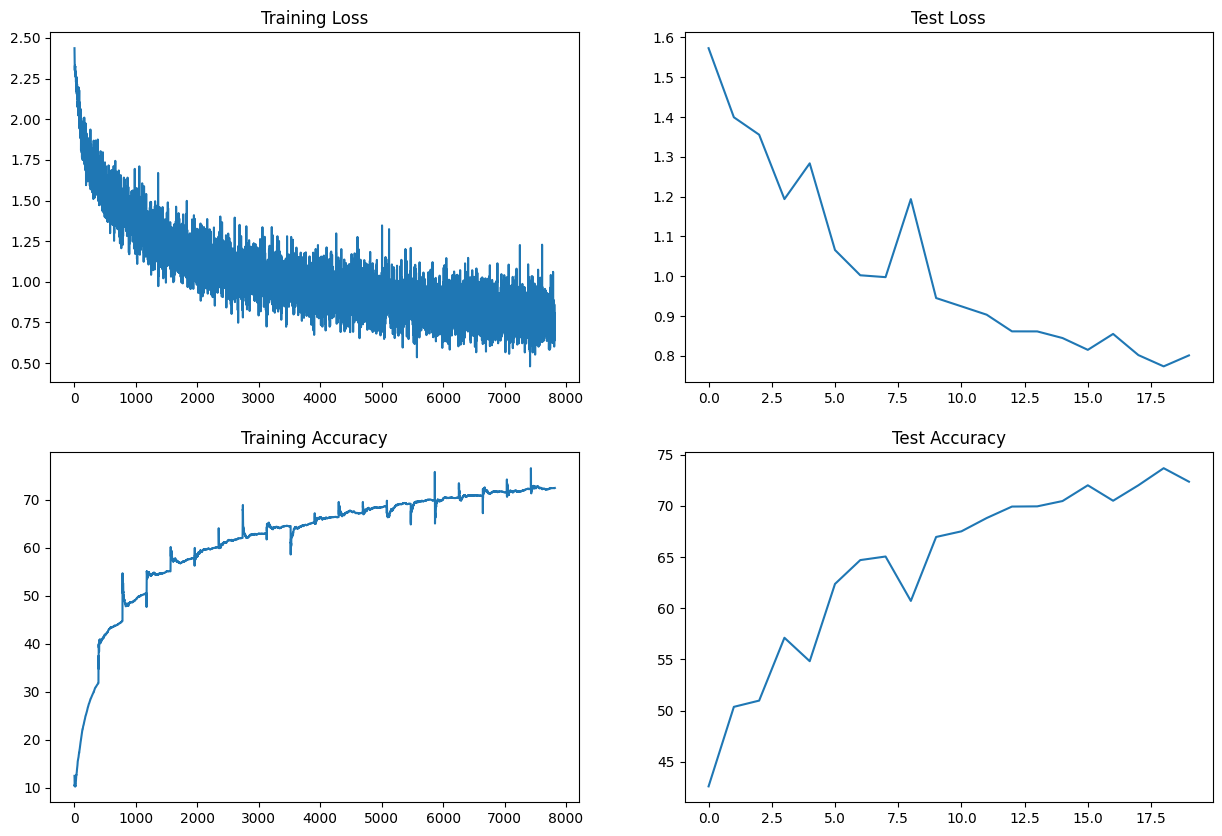

In [25]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

#Misclassified Images across experiments

### Batch Norm model

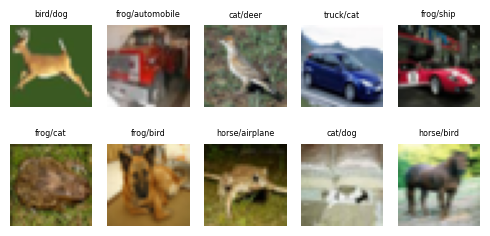

In [46]:
model=torch.load("./modelBatch")

model.eval()
correct = 0
IncorrectIndex=list()
PredClass=list()
TargetClass=list()
with torch.no_grad():
    i=0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        incorrect=torch.where(target.eq(pred.view_as(target))==0)[0].cpu().numpy()
        correct=torch.where(target.eq(pred.view_as(target))==1)[0].cpu().numpy()
        IncorrectIndex=IncorrectIndex + list(incorrect+i)
        if len(incorrect):
            PredClass=PredClass+pred[incorrect].squeeze().tolist()
            TargetClass=TargetClass+target[incorrect].squeeze().tolist()
        i+=128

figure = plt.figure(figsize=(5, 5))
num_of_images = 10

dataiter = iter(test_loader)
images, labels = next(dataiter)
#figure.suptitle('BatchNorm Misclassified Images')

for i,index in enumerate(IncorrectIndex):
    plt.subplot(2,5, i+1)
    plt.axis('off')
    image= inv_normalize(images[index])
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.title(traindata.classes[TargetClass[i]]+"/"+traindata.classes[PredClass[i]],size='xx-small')
    if i==9:
        break
figure.tight_layout()
figure.subplots_adjust(top=0.60)

### Layer Norm model

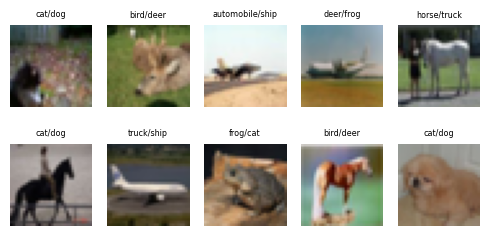

In [49]:
model=torch.load("./modelLayer")

model.eval()
correct = 0
IncorrectIndex=list()
PredClass=list()
TargetClass=list()
with torch.no_grad():
    i=0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        incorrect=torch.where(target.eq(pred.view_as(target))==0)[0].cpu().numpy()
        correct=torch.where(target.eq(pred.view_as(target))==1)[0].cpu().numpy()
        IncorrectIndex=IncorrectIndex + list(incorrect+i)
        if len(incorrect):
            PredClass=PredClass+pred[incorrect].squeeze().tolist()
            TargetClass=TargetClass+target[incorrect].squeeze().tolist()
        i+=128

figure = plt.figure(figsize=(5, 5))
num_of_images = 10

dataiter = iter(test_loader)
images, labels = next(dataiter)
#figure.suptitle('LayerNorm Misclassified Images')

for i,index in enumerate(IncorrectIndex):
    plt.subplot(2,5, i+1)
    plt.axis('off')
    image= inv_normalize(images[index])
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.title(traindata.classes[TargetClass[i]]+"/"+traindata.classes[PredClass[i]],size='xx-small')
    if i==9:
        break
figure.tight_layout()
figure.subplots_adjust(top=0.60)

### Group Norm model

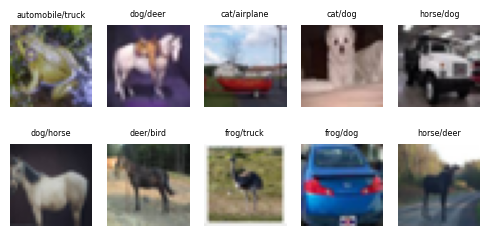

In [48]:
model=torch.load("./modelGroup")

model.eval()
correct = 0
IncorrectIndex=list()
PredClass=list()
TargetClass=list()
with torch.no_grad():
    i=0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        incorrect=torch.where(target.eq(pred.view_as(target))==0)[0].cpu().numpy()
        correct=torch.where(target.eq(pred.view_as(target))==1)[0].cpu().numpy()
        IncorrectIndex=IncorrectIndex + list(incorrect+i)
        if len(incorrect):
            PredClass=PredClass+pred[incorrect].squeeze().tolist()
            TargetClass=TargetClass+target[incorrect].squeeze().tolist()
        i+=128

figure = plt.figure(figsize=(5, 5))
num_of_images = 10

dataiter = iter(test_loader)
images, labels = next(dataiter)
#figure.suptitle('GroupNorm Misclassified Images')

for i,index in enumerate(IncorrectIndex):
    plt.subplot(2,5, i+1)
    plt.axis('off')
    image= inv_normalize(images[index])
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.title(traindata.classes[TargetClass[i]]+"/"+traindata.classes[PredClass[i]],size='xx-small')
    if i==9:
        break
figure.tight_layout()
figure.subplots_adjust(top=0.60)